# Using EcoFOCIpy to process raw field data

*DY2206 - Ecofoci Spring Mooring Cruise*

**Processed by Shaun Bell**

A duplicate column of Fluorescence shows up 
## CTD / Profile Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- SBE workflow must happen first **done (performed on seperate windows system to convert to cnv)**
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added.  Good for quick analysis

Other than hosting on an erddap server, the above can be done at sea

For furthur processing, QC and archiving, the following tasks are to be done *(working or final data level)*:
- Add metadata from cruise yaml files created from cast logs
- apply any calibrations or corrections
    + field corrections
    + offsets
    + spike analysis
    + some QC were available... this would be old-school simple bounds mostly
- save as CF netcdf via xarray or potentially csv file: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is (can be csv as this is useful at sea)
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- TSSigma, TOXYChlor, TurbParTrans


In [1]:
import yaml
import glob

import ecofocipy.io.sbe_ctd_parser as sbe_ctd_parser #<- instrument specific
import ecofocipy.io.ncCFsave as ncCFsave
import ecofocipy.metaconfig.load_config as load_config
import ecofocipy.math.geotools as geotools

## At Sea NRT Processing

In [2]:
sample_data_dir = '/Users/bell/ecoraid/2022/CTDcasts/dy2206/' #root path to cruise directory
ecofocipy_dir = '/Users/bell/Programs/EcoFOCIpy/'

In [3]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'rawconverted/' #<- point to cruise and process all files within
cruise_name = 'DY2206' #no hyphens
inst_meta_file = sample_data_dir+'logs/FOCI_standard_CTD.yaml'
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe9_11p()
filename_list = sorted(glob.glob(datafile + '*.cnv'))

(cruise_data,cruise_header) = cruise.parse(filename_list)

In [4]:
#this line adds available NMEA data to csv files for NRT/Preliminary erddap hosting... if there isn't an NMEA string, you will have to pull the locations
#  from the cast logs and output either a .nc or a more elaborate csv file furthur in to this process
NMEA_location = True
verbose = False

if NMEA_location:
    
    for cast in cruise_header.keys():
        cruise_data[cast][['time','latitude','longitude','profileid']] = ('0',0,0,'0')
        cruise_data[cast][['time','latitude','longitude','profileid']] = (cruise_header[cast]['NMEAtime'],
              geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[0],
              geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[1],
              cast.split('.')[0])
        if verbose:
            print(cruise_header[cast]['NMEAtime'],
                  geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[0],
                  geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[1])

In [5]:
#save downcast csv to file for viewing - really this is just a cleaned up cnv file
import pandas as pd
for cast in cruise_data.keys():
#     print(f'Processing Cast {cast}')
    cruise_data[cast]['time'] = pd.to_datetime(cruise_data[cast]['time'])
    cruise_data[cast].to_csv(sample_data_dir+cast.replace('cnv','csv'))

## Post Cruise Processing with additional meta information

In [8]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'rawconverted/' #<- point to cruise and process all files within
cruise_name = 'DY2206' #no hyphens
cruise_meta_file = sample_data_dir+'logs/DY2206.yaml'
inst_meta_file = sample_data_dir+'logs/FOCI_standard_CTD.yaml'
group_meta_file = ecofocipy_dir+'staticdata/institutional_meta_example_ctd.yaml'
inst_shortname = '' #keep as placeholder for now
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe9_11p()
filename_list = sorted(glob.glob(datafile + '*.cnv'))

(cruise_data,cruise_header) = cruise.parse(filename_list)

## Time Properties

Not traditionally dealt with for CTD files as they are likely dynamically updated via GPS feed.  However, FOCI tends to label the date/time with the ***at depth*** time-stamp

## Depth Properties and other assumptions

- currently, all processing and binning (1m for FOCI) is done via seabird routines and the windows software.  This may change with the python ctd package for a few tasks

## Load all external meta information

In [9]:
#cruise info
with open(cruise_meta_file) as file:
    cruise_config = yaml.full_load(file)

#instrument info
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

#institutional info
with open(group_meta_file) as file:
    group_config = yaml.full_load(file)

In [10]:
inst_config

{'time': {'epic_key': 'TIM_601',
  'name': 'time',
  'generic_name': 'time',
  'standard_name': 'time',
  'long_name': 'date and time since reference time'},
 'depth': {'epic_key': 'D_3',
  'generic_name': 'depth',
  'units': 'meter',
  'long_name': 'depth below surface (meters)',
  'standard_name': 'depth',
  'positive': 'down'},
 'latitude': {'epic_key': 'LON_501',
  'name': 'latitude',
  'generic_name': 'latitude',
  'units': 'degrees_north',
  'long_name': 'latitude',
  'standard_name': 'latitude'},
 'longitude': {'epic_key': 'LAT_500',
  'name': 'longitude',
  'generic_name': 'longitude',
  'units': 'degrees_east',
  'long_name': 'longitude',
  'standard_name': 'longitude'},
 'temperature_ch1': {'epic_key': 'T_28',
  'generic_name': 'temp channel 1',
  'long_name': 'Sea temperature in-situ ITS-90 scale',
  'standard_name': 'sea_water_temperature',
  'units': 'degree_C'},
 'temperature_ch2': {'epic_key': 'T2_35',
  'generic_name': 'temp channel 2',
  'long_name': 'Sea temperature i

In [11]:
cruise_config['CTDCasts']['CTD001']

{'id': 53827,
 'Vessel': 'NOAAS Oscar Dyson',
 'CruiseID': 'DY2206',
 'Project_Leg': '',
 'UniqueCruiseID': 'DY2206',
 'Project': 'FOCI Spring Mooring Survey',
 'StationNo_altname': 's1h1',
 'ConsecutiveCastNo': 'CTD001',
 'LatitudeDeg': 56,
 'LatitudeMin': 51.79,
 'LongitudeDeg': 164,
 'LongitudeMin': 1.91,
 'GMTDay': 11,
 'GMTMonth': 'May',
 'GMTYear': 2022,
 'GMTTime': 50340,
 'DryBulb': -99.9,
 'RelativeHumidity': 95,
 'WetBulb': -99.9,
 'Pressure': 1027,
 'SeaState': '',
 'Visibility': '',
 'WindDir': 275,
 'WindSpd': 14.0,
 'CloudAmt': '',
 'CloudType': '',
 'Weather': '',
 'SurfaceTemp': -99.9,
 'BottomDepth': 72,
 'StationNameID': '70MC',
 'MaxDepth': 68,
 'InstrumentSerialNos': '',
 'Notes': 'Nuts paper label says DY2203, cap labeled Niskin/cast .. const O2 offset between sensors of about 5%\r\nfluor voltage is good, plot data is empty (calibration issue)\r\ndue to rosette setup it is possible first cast had color sampled backwards',
 'NutrientBtlNiskinNo': '1;2;3;4;5;6;7',
 '

In [12]:
cruise_data['ctd001.cnv'].columns

Index(['c0mS/cm', 'c1mS/cm', 'flECO-AFL', 'sbeox0V', 't090C', 't190C', 'timeS',
       'turbWETntu0', 'sbeox1V', 'flECO-AFL_dup', 'par', 'sal00', 'sal11',
       'sigma-t00', 'sigma-t11', 'sbeox0ML/L', 'sbox0Mm/Kg', 'sbeox0PS',
       'sbeox1ML/L', 'sbox1Mm/Kg', 'sbeox1PS', 'nbin', 'flag'],
      dtype='object')

In [13]:
for cast in cruise_data.keys():
    print(f'Processing Cast {cast}')
    try:
        #output cruise cast stats here
        #cruise_data[cast].describe()
        #cruise_data['ctd001.cnv'].hist() - seaborn may have a better summary plot than just a bunch of histograms
        #sns.pairplot(cruise_data[cast])

        cruise_data[cast] = cruise_data[cast].rename(columns={
                            't090C':'temperature_ch1',
                            't190C':'temperature_ch2',
                            'sal00':'salinity_ch1',
                            'sal11':'salinity_ch2',
                            'sbox0Mm/Kg':'oxy_conc_ch1',
                            'sbeox0ML/L':'oxy_concM_ch1',
                            'sbeox0PS':'oxy_percentsat_ch1',
                            'sbox1Mm/Kg':'oxy_conc_ch2',
                            'sbeox1ML/L':'oxy_concM_ch2',
                            'sbeox1PS':'oxy_percentsat_ch2',
                            'sigma-t00':'sigma_t_ch1',
                            'sigma-t11':'sigma_t_ch2',
                            'flECO-AFL':'chlor_fluorescence',
                            'turbWETntu0':'turbidity',
                            'cstarat0':'Attenuation',
                            'cstartr0':'Transmittance',
                            'par':'par',
                            'empty':'empty', #this will be ignored
                            'flag':'flag'})

        cruise_data[cast].index.rename('depth',inplace=True)
        #cruise_data[cast].sample()

        cruise_data_nc = ncCFsave.EcoFOCI_CFnc(df=cruise_data[cast], 
                                    instrument_yaml=inst_config, 
                                    operation_yaml=cruise_config,
                                    operation_type='ctd')
        cruise_data_nc.expand_dimensions(dim_names=['latitude','longitude','time'],geophys_sort=False)
        cruise_data_nc.variable_meta_data(variable_keys=list(cruise_data[cast].columns.values),drop_missing=True)
        cruise_data_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])
        cruise_data_nc.temporal_geospatioal_meta_data_ctd(positiveE=False,conscastno=cast.split('.')[0])

        cruise_data_nc.var_qcflag_init(dim_names=['depth','latitude','longitude','time'])

        #interp to sfc for list of vars
        try:
            cruise_data_nc.interp2sfc(novars=['par'])
        except:
            pass

        #add global attributes
        cruise_data_nc.deployment_meta_add(conscastno=cast.upper().split('.')[0])
        cruise_data_nc.get_xdf()

        #add instituitonal global attributes
        cruise_data_nc.institution_meta_add(group_config)

        #add creation date/time - provenance data
        cruise_data_nc.provinance_meta_add()

        #provide intial qc status field
        cruise_data_nc.qc_status(qc_status='unknown')

        cast_label = cast.split('.')[0].split('d')[-1]
        cruise_data_nc.xarray2netcdf_save(xdf = cruise_data_nc.get_xdf(),
                                filename=sample_data_dir+cruise_name+'c'+cast_label.zfill(3)+'_ctd.nc',format="NETCDF3_CLASSIC")
        #generate editable csv files
        to_edit = True
        if to_edit:
            if not cast[0] in ['d','u']: #dont save editable up and downcast files, just nc files for plotting... all u/d files can be removed after final data
                cruise_data_nc.get_xdf().to_dataframe().to_csv(sample_data_dir+cruise_name+'c'+cast_label.zfill(3)+'_ctd.to_edit.csv')  
        
    except:
       print('Conversion Failed')

Processing Cast ctd001.cnv
Processing Cast ctd002.cnv
Processing Cast ctd003.cnv
Processing Cast ctd004.cnv
Processing Cast ctd005.cnv
Processing Cast ctd006.cnv
Processing Cast ctd007.cnv
Processing Cast ctd008.cnv
Processing Cast ctd009.cnv
Processing Cast ctd010.cnv
Processing Cast ctd011.cnv
Processing Cast ctd012.cnv
Processing Cast ctd013.cnv
Processing Cast ctd014.cnv
Processing Cast ctd015.cnv
Processing Cast ctd016.cnv
Processing Cast ctd017.cnv
Processing Cast ctd018.cnv
Processing Cast ctd019.cnv
Processing Cast ctd020.cnv
Processing Cast ctd021.cnv
Processing Cast ctd022.cnv
Processing Cast ctd023.cnv
Processing Cast ctd024.cnv
Processing Cast ctd025.cnv
Processing Cast ctd026.cnv
Processing Cast ctd027.cnv
Processing Cast ctd028.cnv
Processing Cast ctd029.cnv
Processing Cast dctd001.cnv
Conversion Failed
Processing Cast dctd002.cnv
Conversion Failed
Processing Cast dctd003.cnv
Conversion Failed
Processing Cast dctd004.cnv
Conversion Failed
Processing Cast dctd005.cnv
Conve

## QC Next Steps

In [1]:
import ecofocipy.plots.sbe_ctd_plots as sbe_ctd_plots
import os
import xarray as xa
import seaborn as sns
import numpy as np

In [2]:
sample_data_dir = '/Users/bell/ecoraid/2022/CTDcasts/dy2206/final_data_cf/ctd/' #root path to cruise directory working repo

### QC of data (plot parameters with other instruments)
- be sure to updated the qc_status for the file and the history for future steps
- from NRT csv files... make edits then use that to modify netcdf?
- **Better Yet** export netcdf files with variable flags to csv and edit then reingest and modify
    - modify netcdf in place and provide a qcflag?


### Likely first edits
- research issues noted in cruise logs
- remove failed instrument (clogs, or other challenges that arent correctable)
- extrapolate to sfc (not par though)
- despike depths (interpolate between depths)
- check for common issues
    - lags in salinity when going through interface

DY2206c001_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)0.0002521126760562008,0.0003771125116715922
DY2206c002_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)0.0007068493150679165,0.0012281324241573451
DY2206c003_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)-0.0335492537313432,0.050900237143201216
DY2206c004_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)0.0009787878787887736,0.0017367258599388642
DY2206c005_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)0.00021527777777772015,0.0006093392874942276
DY2206c006_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)-0.00012173913043542568,0.0015565541248350602
DY2206c007_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)0.00029857142857159556,0.002341397193200311
DY2206c008_ctd.nc: Profile Averaged Salinity Difference,STD (chan1-chan2)-0.0007085714285721118,0.005389374277413403
DY2206c009_ctd.nc: Profile Averaged Salinity Difference,STD (cha

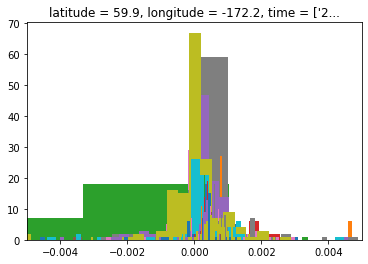

In [25]:
#test for salinity bottle run needs
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        try:
            cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
            saldiff = cruise_data_nc.salinity_ch1 - cruise_data_nc.salinity_ch2
            print(f"{cast}: Profile Averaged Salinity Difference,STD (chan1-chan2){saldiff.mean().values},{saldiff.std().values}")        
            saldiff.plot.hist(bins=50,xlim=[-.005,.005])
        except:
            print(f"{cast}: less than two salinity channels")

In [3]:
# Following routines will eventually get ported to ecofocipy as subroutines to be called

import seawater as sw

def sigmat_update(salinity=None,temperature=None):
    '''
    Changes to T or S (commonly to despike values or apply a salinity offset) will need corresponding changes in sigmat
    '''
    # calculate sigmaT at 0db gauge pressure (s, t, p=0)
    sigt = (sw.eos80.dens0(s=salinity, t=temperature) - 1000)
    
    return sigt


## Generate Plots


### Make General Plots
- 1:1 plots for paired instruments for each cast (tells if a sensor failed)
- TS_Sigmat, Chlor/Par/Turb, Oxy,Temp
- T/S property property plot
- upcast/downcast plt

In [37]:
calc_sigmat = True

for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        if calc_sigmat:
            #update sigmat (or calculate it I suppose)
            sigup = sigmat_update(salinity=ctd_df.salinity_ch1,
                                  temperature=ctd_df.temperature_ch1)
            ctd_df['sigma_t_ch1'] = sigup
            
            sigup2 = sigmat_update(salinity=ctd_df.salinity_ch2,
                                  temperature=ctd_df.temperature_ch2)
            ctd_df['sigma_t_ch2'] = sigup2   
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot3var(varname=['temperature_ch1','temperature_ch2','salinity_ch1','salinity_ch2','sigma_t_ch1','sigma_t_ch2'],
                          xdata=[ctd_df.temperature_ch1,ctd_df.temperature_ch2,ctd_df.salinity_ch1,ctd_df.salinity_ch2,ctd_df.sigma_t_ch1,ctd_df.sigma_t_ch2],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['Temperature','Salinity','Sigma-T'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.replace('.nc','_TempSalSigmat.png'))
        plt.close(fig)

In [4]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot2var(varname=['temperature_ch1','temperature_ch2','oxy_percentsat_ch1','oxy_percentsat_ch2'],
                          xdata=[ctd_df.temperature_ch1,ctd_df.temperature_ch2,ctd_df.oxy_percentsat_ch1,ctd_df.oxy_percentsat_ch2],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['Temperature','Oxygen Saturation'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.replace('.nc','_TempOxy.png'))
        plt.close(fig)

/Users/bell/Programs/EcoFOCIpy/src/ecofocipy/plots/sbe_ctd_plots.py:81: RuntimeWarning: All-NaN axis encountered
  abmin=np.nanmin([np.nanmin(xdata[0]),np.nanmin(xdata[1])])
/Users/bell/Programs/EcoFOCIpy/src/ecofocipy/plots/sbe_ctd_plots.py:82: RuntimeWarning: All-NaN axis encountered
  abmax=np.nanmax([np.nanmax(xdata[0]),np.nanmax(xdata[1])])
/Users/bell/Programs/EcoFOCIpy/src/ecofocipy/plots/sbe_ctd_plots.py:108: RuntimeWarning: All-NaN axis encountered
  abmin=np.nanmin([np.nanmin(xdata[2]),np.nanmin(xdata[3])])
/Users/bell/Programs/EcoFOCIpy/src/ecofocipy/plots/sbe_ctd_plots.py:109: RuntimeWarning: All-NaN axis encountered
  abmax=np.nanmax([np.nanmax(xdata[2]),np.nanmax(xdata[3])])


In [30]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot3var(varname=['turbidity','','chlor_fluorescence','','par'],
                          xdata=[ctd_df.turbidity,np.array([]),ctd_df.chlor_fluorescence,np.array([]),ctd_df.par,np.array([])],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=False,
                          xlabel=['Turbidity','Fluor','Par'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.replace('.nc','_TurbFluorPAR.png'))
        plt.close(fig)

# Cross Sections

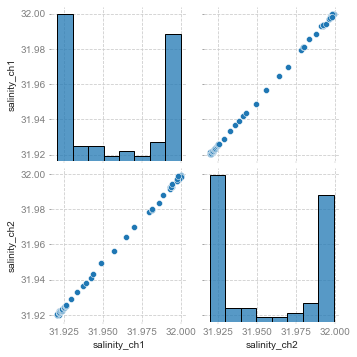

In [31]:
#cruise_data_nc.get_xdf().to_dataframe().columns
sns.pairplot(cruise_data_nc.to_dataframe()[['salinity_ch1', 'salinity_ch2',]])

In [ ]:
# ## Export data from nc files
# for cast in sorted(os.listdir(sample_data_dir+'working/')):
#     if cast.endswith('.nc'):
#         cruise_data_nc = xa.load_dataset(sample_data_dir+'working/'+cast)
#         cruise_data_nc.to_dataframe().to_csv(sample_data_dir+'working/'+cast.replace('.nc','.to_edit.csv') )